### 0. import dependencies

In [1]:
import torch
from torch import optim
import torch.nn.functional as F
from torchmetrics import AUROC, Precision, Recall, PearsonCorrCoef, SpearmanCorrCoef

from models.PropertyRegressors import PropertyRegressors

from datasets.get_fingerprints import get_fingerprints
from datasets.get_molecular_descriptors import get_molecular_descriptors
from datasets.get_chembert2as import get_chembert2as
from datasets.get_molformers import get_molformers
from datasets.create_data_loaders import create_data_loaders

from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchmetrics import AUROC
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'device is {device}')

/home/heechan/miniconda3/envs/midexam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device is cuda


### 1. get features and embeddings

In [2]:
task = 'classification'

descriptors = get_molecular_descriptors(task).to(device)
print(f"descriptor tensor shape: {descriptors.shape}")  # [num_samples, 210]

fingerprints, label_tensor = get_fingerprints(task)
print(f"fingerprint tensor shape: {fingerprints.shape}")  # [num_samples, 2048]

chembert2as = get_chembert2as(task).to(device)
print(f"chembert2a tensor shape: {chembert2as.shape}")  # [num_samples, 600]

molformers = get_molformers(task).to(device)
print(f"molformers tensor shape: {molformers.shape}")  # [num_samples, 768]

get_molecular_descriptors: 100%|██████████| 7807/7807 [01:49<00:00, 71.06it/s] 



Descriptor statistics before normalization:
             MolMR      fr_Ar_N     SMR_VSA3  VSA_EState5  fr_isothiocyan  \
count  7807.000000  7807.000000  7807.000000  7807.000000          7807.0   
mean    101.492043     0.504291     7.710011    -0.605834             0.0   
std      43.075344     1.055688     8.443447     2.534573             0.0   
min       0.000000     0.000000     0.000000   -49.570148             0.0   
25%      78.130150     0.000000     0.000000    -1.461930             0.0   
50%      97.283997     0.000000     5.316789     0.000000             0.0   
75%     116.637398     1.000000    10.216699     0.622251             0.0   
max     517.722778     8.000000   105.004532    11.713348             0.0   

       fr_C_O_noCOO        fr_SH  FpDensityMorgan1  SlogP_VSA12  \
count   7807.000000  7807.000000       7807.000000  7807.000000   
mean       1.316639     0.002306          1.174025     6.291317   
std        1.521192     0.053038          0.226806    10.906

get_fingerprints: 100%|██████████| 7807/7807 [00:01<00:00, 4018.68it/s]


fingerprint tensor shape: torch.Size([7807, 2048])


get_chembert2as: 100%|██████████| 7807/7807 [00:29<00:00, 265.64it/s]


chembert2a tensor shape: torch.Size([7807, 600])


get_molformers: 100%|██████████| 7807/7807 [02:56<00:00, 44.19it/s]

molformers tensor shape: torch.Size([7807, 768])


### 2. set train and val loaders

In [3]:
train_loader, val_loader = create_data_loaders(
    descriptors=descriptors,
    fingerprints=fingerprints,
    chembert2as=chembert2as,
    molformers=molformers,
    labels=label_tensor,
    batch_size=1024
)

num_epochs = 250

### 3. set and train the model

In [4]:
# Initialize model, optimizer, and loss function
model = PropertyRegressors(128, 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30, T_mult=1, eta_min=1e-6, last_epoch=-1)
criterion = torch.nn.BCEWithLogitsLoss() if task == 'classification' else torch.nn.MSELoss()

# Training loop
epoch_loss = 0.0
epoch_val_loss = 0.0

metrics = {
    'classification': [AUROC('binary').to(device), Precision('binary').to(device), Recall('binary').to(device)],
    'regression': [PearsonCorrCoef().to(device), SpearmanCorrCoef().to(device)]
}

train_losses = []
val_losses = []

train_metrics = {metric.__class__.__name__: [] for metric in metrics[task]}
val_metrics = {metric.__class__.__name__: [] for metric in metrics[task]}

train_lambdas = []

epoch_val_predictions = []
epoch_val_labels = []

for _ in tqdm(range(num_epochs), 'Epoch'):
    # Training phase
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()

        desc = batch['descriptors']
        fps = batch['fingerprints']
        chembert = batch['chembert2as']
        molformer = batch['molformers']
        labels = batch['label']

        # desc = torch.zeros_like(desc)
        # fps = torch.zeros_like(fps)
        # chembert = torch.zeros_like(chembert)
        # molformer = torch.zeros_like(molformer)

        predictions, lambdas = model(desc, fps, chembert, molformer)
        loss = criterion(predictions, labels)

        for metric in metrics[task]:
            metric.update(predictions, labels)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # End of training epoch
    scheduler.step()
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    # Record training metrics
    for metric in metrics[task]:
        metric_value = metric.compute()
        train_metrics[metric.__class__.__name__].append(metric_value.detach().cpu())
        metric.reset()

    train_lambdas.append(lambdas.detach().cpu())
    epoch_loss = 0.0

    # Validation phase
    model.eval()
    with torch.no_grad():
        batch_val_predictions = []
        batch_val_labels = []

        for batch in val_loader:
            desc = batch['descriptors']
            fps = batch['fingerprints']
            chembert = batch['chembert2as']
            molformer = batch['molformers']
            val_labels = batch['label']

            # desc = torch.zeros_like(desc)
            # fps = torch.zeros_like(fps)
            # chembert = torch.zeros_like(chembert)
            # molformer = torch.zeros_like(molformer)

            val_predictions, val_lambdas = model(desc, fps, chembert, molformer)
            loss = criterion(val_predictions, val_labels)

            for metric in metrics[task]:
                metric.update(val_predictions, val_labels)

            epoch_val_loss += loss.item()
            batch_val_predictions.extend(val_predictions.sigmoid().detach().cpu() if task == 'classification' else val_predictions.detach().cpu())
            batch_val_labels.extend(val_labels.detach().cpu())

        # Record validation metrics
        avg_epoch_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_epoch_val_loss)

        for metric in metrics[task]:
            metric_value = metric.compute()
            val_metrics[metric.__class__.__name__].append(metric_value.detach().cpu())
            metric.reset()

        epoch_val_predictions.append(batch_val_predictions)
        epoch_val_labels.append(batch_val_labels)
        epoch_val_loss = 0.0

print(lambdas)

Epoch: 100%|██████████| 250/250 [01:04<00:00,  3.86it/s]

tensor([[0.2362],
        [0.2409],
        [0.2653],
        [0.2576]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


### 4. visualize the learning process and check the best performance

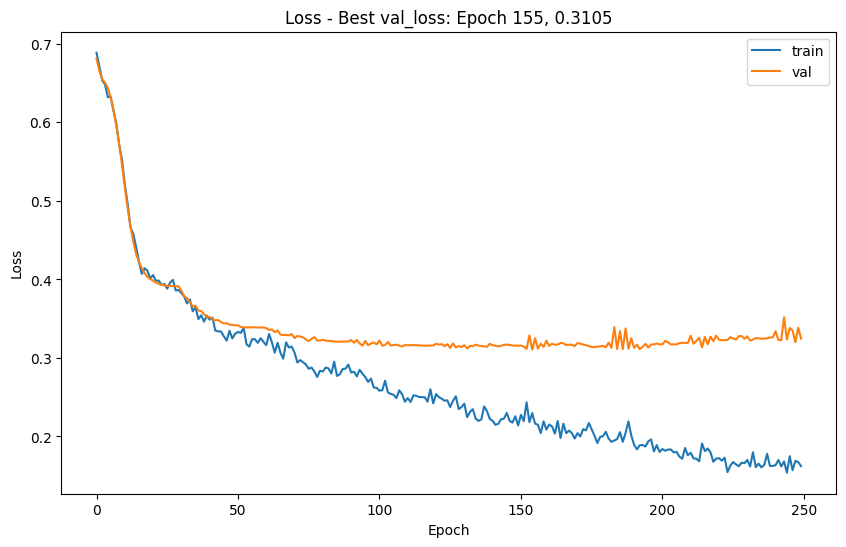

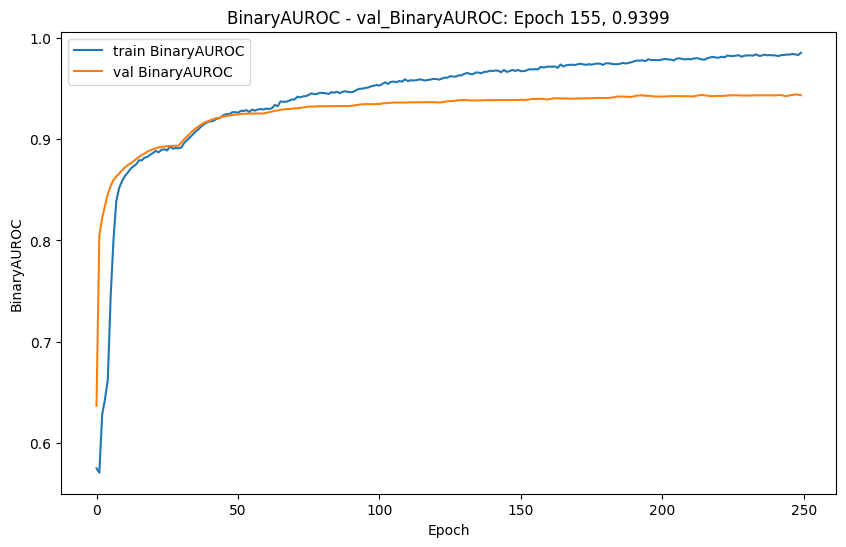

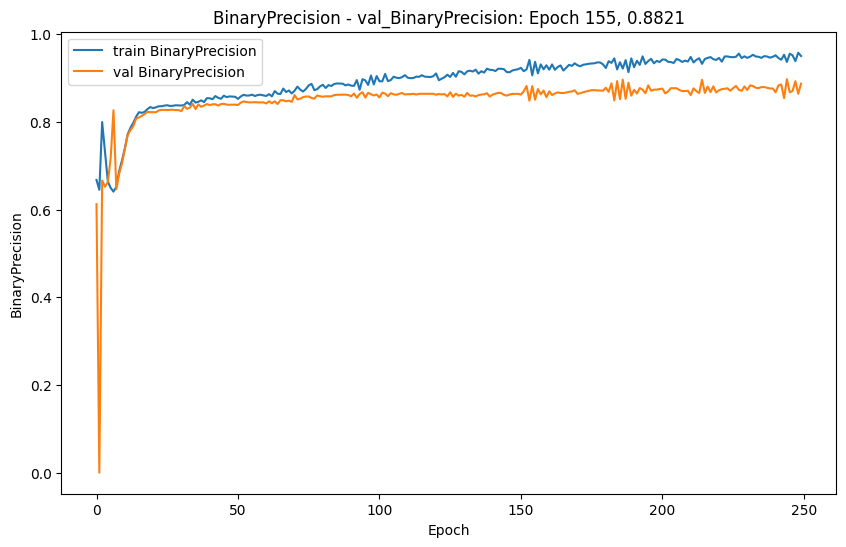

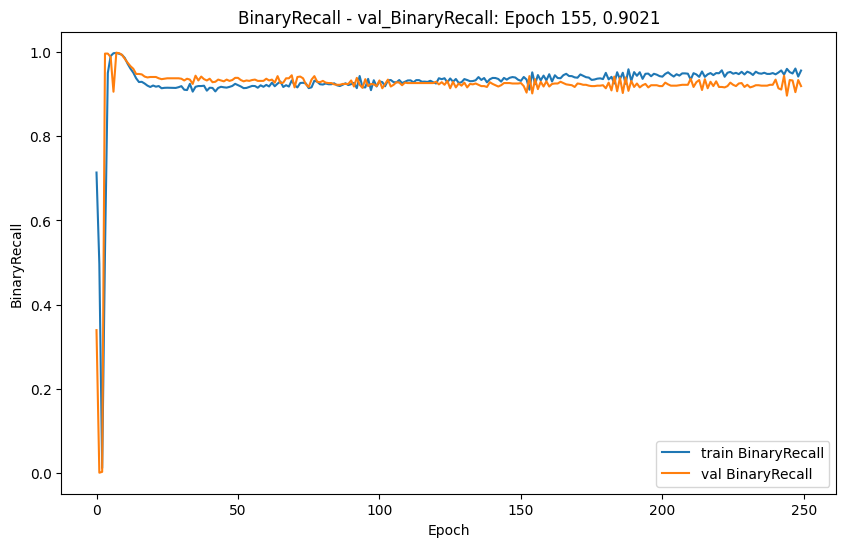

In [5]:
# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
val_loss_best_epoch = np.argmin(val_losses)
plt.title(f'Loss - Best val_loss: Epoch {val_loss_best_epoch+1}, {val_losses[val_loss_best_epoch]:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot metrics
for metric_name in train_metrics.keys():
    plt.figure(figsize=(10, 6))
    
    train_metric_values = [x.item() if torch.is_tensor(x) else x for x in train_metrics[metric_name]]
    val_metric_values = [x.item() if torch.is_tensor(x) else x for x in val_metrics[metric_name]]
    
    plt.plot(train_metric_values, label=f'train {metric_name}')
    plt.plot(val_metric_values, label=f'val {metric_name}')
    
    best_value = val_metric_values[val_loss_best_epoch]
    
    plt.title(f'{metric_name} - val_{metric_name}: Epoch {val_loss_best_epoch+1}, {best_value:.4f}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()


### 5. visualize the predicted distributions by class at the best performing epoch

Epoch 154: val BinaryAUROC: 0.940
Epoch 154: val BinaryPrecision: 0.882
Epoch 154: val BinaryRecall: 0.902


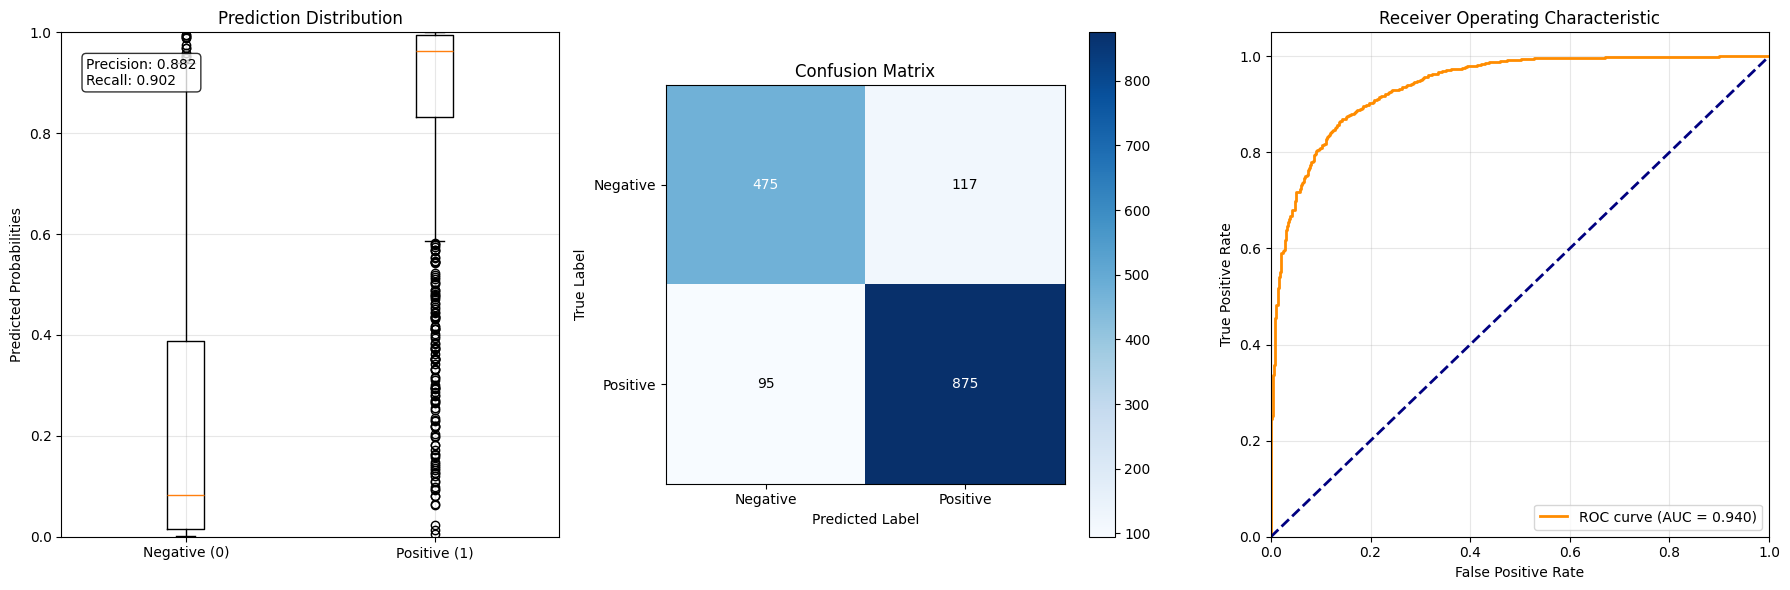


Metrics Summary:
Accuracy: 0.864
Precision: 0.882
Recall: 0.902
F1 Score: 0.892
AUC-ROC: 0.940


In [6]:
# Find best epoch based on validation metrics
val_best_epoch = np.argmin(val_losses)  # or use appropriate metric

# Print best metrics for each metric type
for metric_name in val_metrics.keys():
    best_value = val_metrics[metric_name][val_best_epoch]
    print(f"Epoch {val_best_epoch}: val {metric_name}: {best_value:.3f}")

# Convert to numpy for plotting
L = np.array(epoch_val_labels[val_best_epoch])
P = np.array(epoch_val_predictions[val_best_epoch])

if task == 'classification':
    # Create a figure with 1x3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Box plot
    ax1.boxplot([P[L.flatten() == 0].flatten(), P[L.flatten() == 1].flatten()], 
              labels=['Negative (0)', 'Positive (1)'])
    ax1.set_ylabel('Predicted Probabilities')
    ax1.set_ylim(0, 1)
    
    precision_val = val_metrics['BinaryPrecision'][val_best_epoch]
    recall_val = val_metrics['BinaryRecall'][val_best_epoch]
    
    ax1.text(0.05, 0.95, 
           f'Precision: {precision_val:.3f}\nRecall: {recall_val:.3f}',
           transform=ax1.transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax1.set_title('Prediction Distribution')
    ax1.grid(True, alpha=0.3)

    # 2. Confusion Matrix
    P_binary = (P > 0.5).astype(int)
    cm = confusion_matrix(L, P_binary)
    
    im = ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix')
    plt.colorbar(im, ax=ax2)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax2.set_xticks([0, 1])
    ax2.set_yticks([0, 1])
    ax2.set_xticklabels(['Negative', 'Positive'])
    ax2.set_yticklabels(['Negative', 'Positive'])
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    # 3. ROC Curve
    fpr, tpr, _ = roc_curve(L, P)
    roc_auc = auc(fpr, tpr)

    ax3.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Receiver Operating Characteristic')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\nMetrics Summary:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"AUC-ROC: {roc_auc:.3f}")

else:
    # Scatter plot for regression
    plt.scatter(L, P, alpha=0.5)
    
    # Calculate and plot regression line
    z = np.polyfit(L.flatten(), P.flatten(), 1)
    p = np.poly1d(z)
    plt.plot(L, p(L), "r--", alpha=0.8)
    
    # Add correlation coefficient
    for metric_name, values in val_metrics.items():
        best_value = values[val_best_epoch]
        plt.text(0.05, 0.95 - 0.05 * list(val_metrics.keys()).index(metric_name),
                f'{metric_name}: {best_value:.3f}',
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.ylabel('Predicted Values')
    plt.xlabel('Experimental Values')

### 6. visualize the learned ratio of the input features

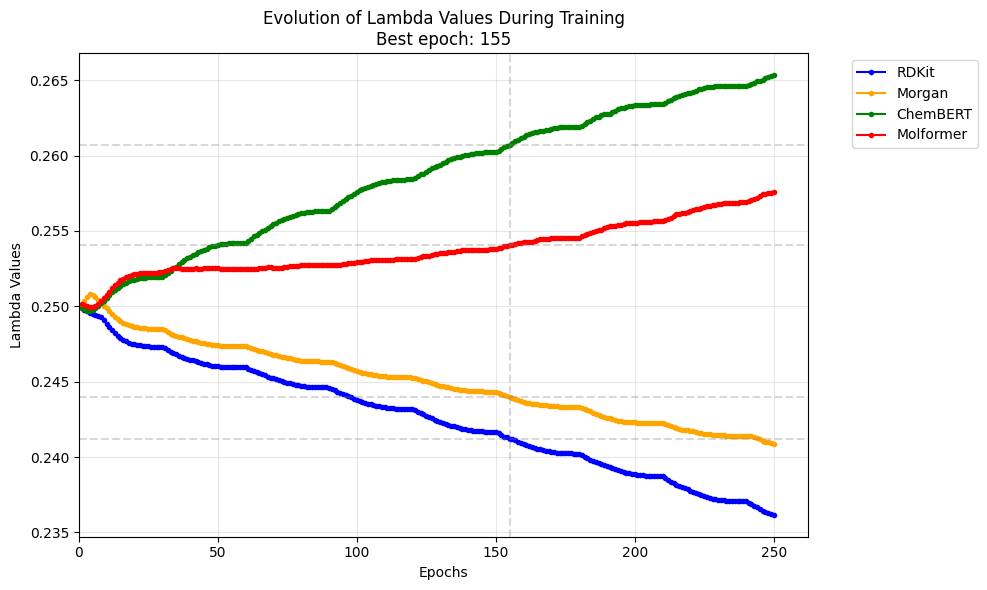


Lambda values at best epoch:
RDKit: 0.241
Morgan: 0.244
ChemBERT: 0.261
Molformer: 0.254


In [7]:
# Convert list of lambdas to numpy array for easier plotting
lambdas_array = np.array(train_lambdas)  # shape: [n_epochs, 4, 1]
lambdas_array = lambdas_array.squeeze()  # shape: [n_epochs, 4]

# Create figure
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_lambdas) + 1)

# Define colors and labels
colors = ['b', 'orange', 'g', 'r', 'gray']
labels = ['RDKit', 'Morgan', 'ChemBERT', 'Molformer']

# Plot lambda evolution
for i in range(4):
    plt.plot(epochs, lambdas_array[:, i], 
             label=labels[i], 
             marker='.', 
             c=colors[i])

# Add horizontal lines at best epoch values
for i in range(4):
    plt.axhline(y=lambdas_array[val_best_epoch, i], 
                ls='--', 
                c=colors[-1], 
                alpha=0.3)

# Add vertical line at best epoch
plt.axvline(x=val_best_epoch+1, 
            ls='--', 
            c=colors[-1], 
            alpha=0.3)

# Format lambda values for title
lambda_values = [f"{v:.3f}" for v in lambdas_array[val_best_epoch]]
lambda_text = ", ".join(lambda_values)

# Customize plot
plt.xlabel('Epochs')
plt.ylabel('Lambda Values')
plt.title(f'Evolution of Lambda Values During Training\n'
          f'Best epoch: {val_best_epoch+1}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0)
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Optional: Print lambda values at best epoch
print("\nLambda values at best epoch:")
for label, value in zip(labels, lambdas_array[val_best_epoch]):
    print(f"{label}: {value:.3f}")